# 🪐 Image Processing with the Thunderbird South Telescope 📸
##### CCD Image Calibration and Color Reconstruction
#####(or more technoically, CCD Image Calibration and Color Reconstruction)
<u>solutions</u>

---

The following notebook holds the solutions, as well as the full working code for the UBC astronomy club coding workshop 2

The full code also precomputes some calibrated fits to be used in the actual workshop without recomputation. These fits are stored in the same drive location.

created by Wrik Steven Sen


In [1]:
# file path setup to import files directly from drive
########################################################
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# path setup for convinience
########################################################
path = "/content/drive/MyDrive/Colab Notebooks/workshop2/M8_data"

# change directory appropriately
########################################################
import sys
import os

sys.path.append(path)
os.chdir(path)

In [3]:
# check working directory
########################################################
!pwd
!ls

/content/drive/.shortcut-targets-by-id/1TjHLIM8j1vg5vW6IPNOM4OQ2Lp4g8H2P/M8_data
10s_DarksForFlats    calibrated_V_frames   master_flat_B.fits
60s_DarksForImage    combined_BVR.fits	   master_flat_R.fits
B		     Flat_B		   master_flat_V.fits
calibrated_B.fits    Flat_R		   R
calibrated_B_frames  Flat_V		   uncalibrated_V.fits
calibrated_R.fits    M8_RGB.png		   V
calibrated_R_frames  master_dark_10s.fits
calibrated_V.fits    master_dark_60s.fits


## <u>Code for the actual workshop, below

In [4]:
%pip install ccdproc

In [5]:
# imports
########################################################
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.nddata import CCDData
from astropy.stats import mad_std
from astropy import units as u
import ccdproc
import glob
import os

In [6]:
# Helper functions
########################################################
def plot_side_by_side(image1, image2, title1, title2, figsize=(12, 6)):
  """
  takes two images and plots them side by side
  """
  norm1 = ImageNormalize(image1, interval=ZScaleInterval())
  norm2 = ImageNormalize(image2, interval=ZScaleInterval())
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  axes[0].imshow(image1, cmap='gray', origin='lower', norm= norm1)
  axes[0].set_title(title1)
  axes[0].axis('off')

  axes[1].imshow(image2, cmap='gray', origin='lower', norm= norm2)
  axes[1].set_title(title2)
  axes[1].axis('off')

  plt.tight_layout()
  plt.show()

def plot_single(image, title, figsize=(8,8)):
  """
  takes a single image and plots it
  """
  norm = ImageNormalize(image, interval=ZScaleInterval())

  plt.figure(figsize=(8,8))
  plt.imshow(image, cmap='gray', origin='lower', norm=norm)
  plt.title(title)
  plt.colorbar(label='ADU')
  plt.show()


def calibration_pipline(data, master_dark, master_flat, output_dir, prefix):
  """
  calibrate all science frames for a given filter.

  Parameters
  ----------
  file_list : list
      List of FITS file paths to calibrate.
  master_dark : CCDData
      Master dark frame (CCDData object).
  master_flat : CCDData
      Master flat frame (CCDData object).
  output_dir : str
      Directory to save calibrated frames.
  prefix : str
      Prefix for naming the calibrated FITS files.
  """
  os.makedirs(output_dir, exist_ok=True)
  l = len(data)

  # Read in science frames
  for i, f in enumerate(data):
    print(f"Processing frame {i+1}/{l}: {f}")

    sci = CCDData.read(f, unit='adu')

    # Subtract dark
    sci_corr = ccdproc.subtract_dark(
        sci,
        master_dark,
        exposure_time='EXPTIME',
        exposure_unit=u.second
    )

    # Apply flat correction
    sci_corr = ccdproc.flat_correct(sci_corr, master_flat)

    # Save calibrated frame
    output_name = os.path.join(output_dir, f"{prefix}_{i:03d}.fits")
    sci_corr.write(output_name, overwrite=True)

    # Free memory before next loop
    del sci, sci_corr

  print(f"{l} frames calibrated and saved in {output_dir}")


def combine_frames(calibrated_files, output_name):
  """
  combines the calibrated frames into a single image
  """
  l = len(calibrated_files)
  # Initialize accumulation variables
  sum_image = None
  count = 0

  for i, f in enumerate(calibrated_files):
    data = fits.getdata(f).astype(np.float32)  # ensure numeric

    if sum_image is None:
      sum_image = np.zeros_like(data)

    sum_image += data
    count += 1

    if (i + 1) % 10 == 0 or (i + 1) == l:
      print(f"Added {i+1}/{l} frames")

  # Compute average on the fly
  stacked = sum_image / count
  fits.writeto(output_name, stacked, overwrite=True)


# uses too much RAM
##############################
# def combine_frames(calibrated_files, output_name, use_sigma_clip=True, low_thresh=3.0, high_thresh=3.0):
#     """
#     Combine a list of calibrated FITS files into a single image,
#     optionally applying sigma clipping.
#     """
#     print(f"🔭 Combining {len(calibrated_files)} frames...")

#     # Load all files as CCDData objects
#     data_list = [ccdproc.CCDData.read(f, unit='adu') for f in calibrated_files]

#     # Combine with sigma clipping (robust to outliers)
#     combined = ccdproc.combine(
#         data_list,
#         method='average',
#         sigma_clip=use_sigma_clip,
#         sigma_clip_low_thresh=low_thresh,
#         sigma_clip_high_thresh=high_thresh,
#         sigma_clip_func=np.ma.median
#     )

#     combined.write(output_name, overwrite=True)
#     print(f"✅ Combined image saved as '{output_name}'")


## Import all the files

In [7]:
#Load Calibration and Science Data
########################################################
# darks
darks_for_images = glob.glob('60s_DarksForImage/M8_D_*.fits')
darks_for_flats = glob.glob('10s_DarksForFlats/dark10s_*.fits')
# flats
flat_files_V = glob.glob('Flat_V/flatV_*.fits')
flat_files_R = glob.glob('Flat_R/flatR_*.fits')
flat_files_B = glob.glob('Flat_B/flatB_*.fits')
# science images
V_files    = glob.glob('V/M8_V_*.fits')
# color filters
R_files    = glob.glob('R/M8_R_*.fits')
G_files    = glob.glob('G/M8_G_*.fits')
B_files    = glob.glob('B/M8_B_*.fits')

# sanity check
print(f"Darks --> darks for images(60s): {len(darks_for_images)}, darks for flats(10s): {len(darks_for_flats)}")
print(f"Flats --> flats for science frame: {len(flat_files_V)}, flats for reds: {len(flat_files_R)}, flats for blues: {len(flat_files_B)}")
print(f"Science frames --> {len(V_files)}")
print(f"R: {len(R_files)}, G: {len(G_files)}, B: {len(B_files)}")

Darks --> darks for images(60s): 10, darks for flats(10s): 7
Flats --> flats for science frame: 7, flats for reds: 7, flats for blues: 7
Science frames --> 70
R: 70, G: 0, B: 70


In [8]:
# sanity check
hdr = fits.getheader(V_files[0])
print(list(hdr.keys()))

['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'CAMERA', 'UTSTART', 'OBJ-NAME', 'FACILITY', 'DATE', 'DATE-OBS', 'DOY', 'EXPTYPE', 'EXPTIME', 'XBIN', 'YBIN', 'XPIXSIZE', 'YPIXSIZE', 'UTMID', 'UTC', 'MJD-OBS', 'FILTER', 'FRAME-NO', 'BSCALE', 'BZERO']


## Create the calibration pipeline
### create the calibration frames

####<u>Creating the master dark frame</u>

In [9]:
# Create Master Dark
########################################################
dark_list = [CCDData.read(f, unit='adu') for f in darks_for_images]
master_dark = ccdproc.combine(dark_list, method='median', sigma_clip=True, sigma_clip_low_thresh=3, sigma_clip_high_thresh=3, sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)
master_dark.write('master_dark_60s.fits', overwrite=True)

In [10]:
# Create Master Dark for Flats
########################################################
flat_dark_list = [CCDData.read(f, unit='adu') for f in darks_for_flats]
master_flat_dark = ccdproc.combine(flat_dark_list, method='median', sigma_clip=True, sigma_clip_low_thresh=3, sigma_clip_high_thresh=3, sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)
master_flat_dark.write('master_dark_10s.fits', overwrite=True)

####<u>Creating the master flat frame</u>

In [11]:
#  Master Flat for V filter
########################################################
# Read flat files
flat_list_V = [CCDData.read(f, unit='adu') for f in flat_files_V]

# Subtract 10s master dark frame
flat_corr_V = [ccdproc.subtract_dark(f,
                                     master_flat_dark,
                                     exposure_time='EXPTIME',
                                     exposure_unit=u.second,
                                     scale = False
                                     ) for f in flat_list_V]

# Combine and normalize
master_flat_V = ccdproc.combine(flat_corr_V, method='median', sigma_clip=True, sigma_clip_low_thresh=3, sigma_clip_high_thresh=5, sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)
master_flat_V = master_flat_V.divide(np.median(master_flat_V.data))
master_flat_V.write('master_flat_V.fits', overwrite=True)

####<u>Visualizing only the noise from the calibration frames</u>

This is a visualization of only the noise in the image data we have. We want to remove this noise from our actual data.

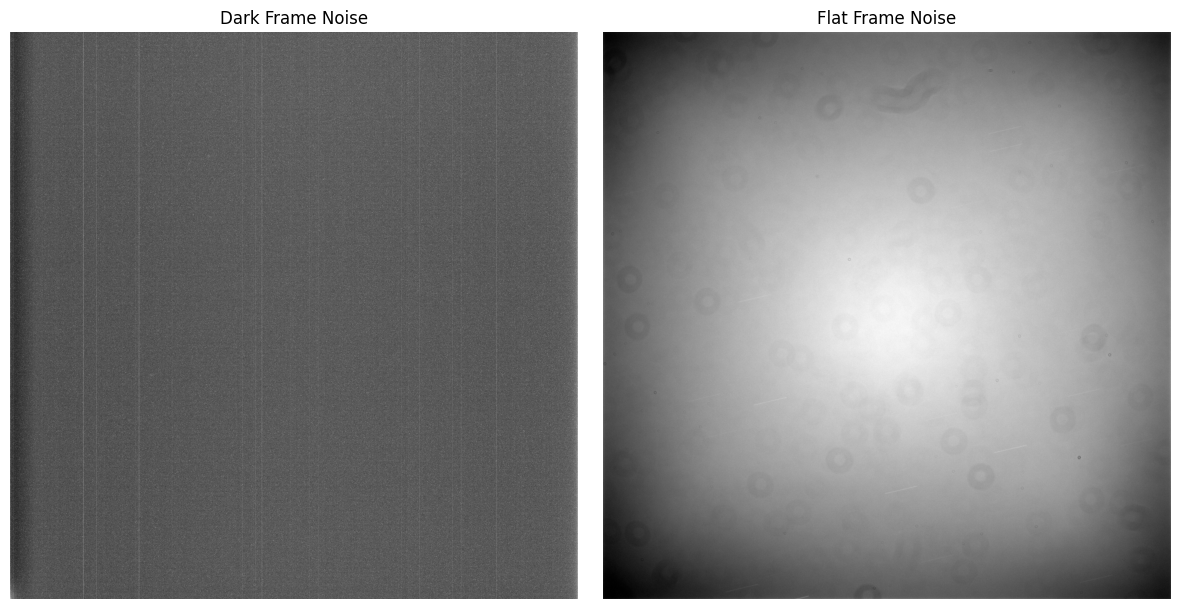

In [12]:
plot_side_by_side(master_dark, master_flat_V, "Dark Frame Noise", "Flat Frame Noise")

####<u>Visualizing The image **WITH** the noise frames</u>

This is a visualization of only the noise in the image data we have. We want to remove this noise from our actual data.

In [13]:
uncalibrated_V = V_files

combine_frames(uncalibrated_V, 'uncalibrated_V.fits')

Added 10/70 frames
Added 20/70 frames
Added 30/70 frames
Added 40/70 frames
Added 50/70 frames
Added 60/70 frames
Added 70/70 frames


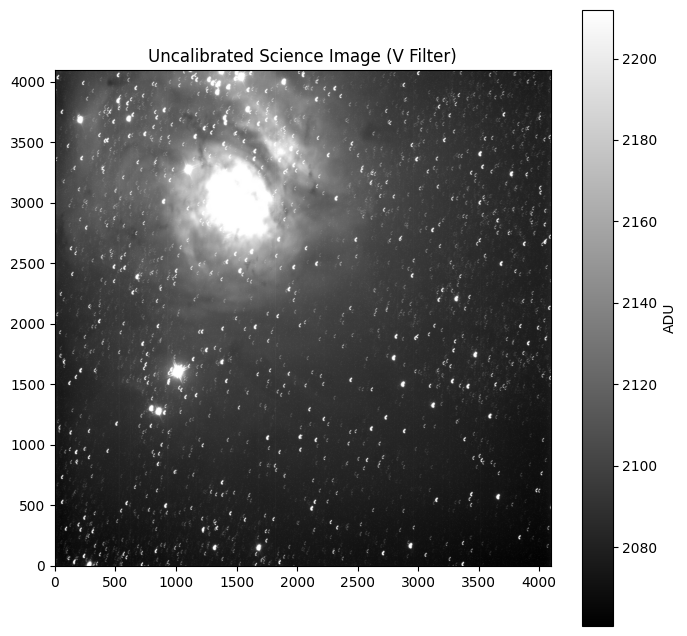

In [14]:
uncalibrated_data_V = fits.getdata('uncalibrated_V.fits')
plot_single(uncalibrated_data_V, "Uncalibrated Science Image (V Filter)")

####<u>Processing the Image</u>

Remove noise data from the image

In [15]:
# Calibrate the Science Frames (V)
########################################################
calibration_pipline(V_files, master_dark, master_flat_V, 'calibrated_V_frames', 'calibrated_V')

Processing frame 1/70: V/M8_V_079_2025_00002-28054.fits


/usr/local/lib/python3.12/dist-packages/astropy/units/quantity.py:653: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/lib/python3.12/dist-packages/astropy/nddata/nduncertainty.py:877: RuntimeWarning: invalid value encountered in divide
  (left + right + correlation_sign * corr)


Processing frame 2/70: V/M8_V_079_2025_00002-28055.fits
Processing frame 3/70: V/M8_V_079_2025_00002-28056.fits
Processing frame 4/70: V/M8_V_079_2025_00002-28057.fits
Processing frame 5/70: V/M8_V_079_2025_00002-28058.fits
Processing frame 6/70: V/M8_V_079_2025_00002-28059.fits
Processing frame 7/70: V/M8_V_079_2025_00002-28060.fits
Processing frame 8/70: V/M8_V_079_2025_00002-28061.fits
Processing frame 9/70: V/M8_V_079_2025_00002-28062.fits
Processing frame 10/70: V/M8_V_079_2025_00002-28063.fits
Processing frame 11/70: V/M8_V_079_2025_00002-28064.fits
Processing frame 12/70: V/M8_V_079_2025_00002-28065.fits
Processing frame 13/70: V/M8_V_079_2025_00002-28066.fits
Processing frame 14/70: V/M8_V_079_2025_00002-28067.fits
Processing frame 15/70: V/M8_V_079_2025_00002-28068.fits
Processing frame 16/70: V/M8_V_079_2025_00002-28069.fits
Processing frame 17/70: V/M8_V_079_2025_00002-28070.fits
Processing frame 18/70: V/M8_V_079_2025_00002-28071.fits
Processing frame 19/70: V/M8_V_079_2025

In [16]:
calibrated_files = sorted(glob.glob('calibrated_V_frames/calibrated_V_*.fits'))

combine_frames(calibrated_files, 'calibrated_V.fits')

Added 10/70 frames
Added 20/70 frames
Added 30/70 frames
Added 40/70 frames
Added 50/70 frames
Added 60/70 frames
Added 70/70 frames


####<u>Visualizing The image **WITHOUT** the noise frames</u>

This is a visualization of only the noise in the image data we have. We want to remove this noise from our actual data.

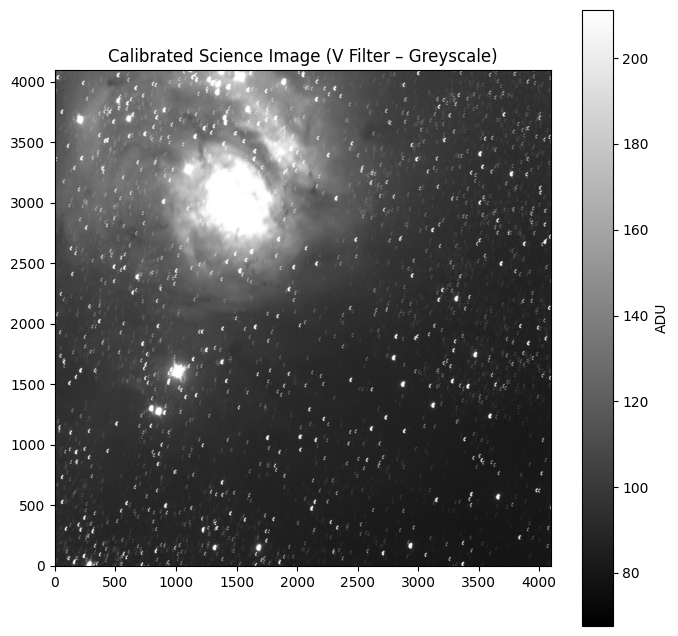

In [17]:
# display greyscale
########################################################
data_V = fits.getdata('calibrated_V.fits')
plot_single(data_V, "Calibrated Science Image (V Filter – Greyscale)")

## Repeat the calibration pipeline for colored fits

### RED

In [10]:
#  Master Flat for R filter
########################################################
# Read flat files
flat_list_R = [CCDData.read(f, unit='adu') for f in flat_files_R]

# Subtract 10s master dark frame
flat_corr_R = [ccdproc.subtract_dark(f,
                                     master_flat_dark,
                                     exposure_time='EXPTIME',
                                     exposure_unit=u.second,
                                     scale = False
                                     ) for f in flat_list_R]

# Combine and normalize
master_flat_R = ccdproc.combine(flat_corr_R, method='median', sigma_clip=True, sigma_clip_low_thresh=2.0, sigma_clip_high_thresh=2.5, sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)
master_flat_R = master_flat_R.divide(np.median(master_flat_R.data))
master_flat_R.write('master_flat_R.fits', overwrite=True)

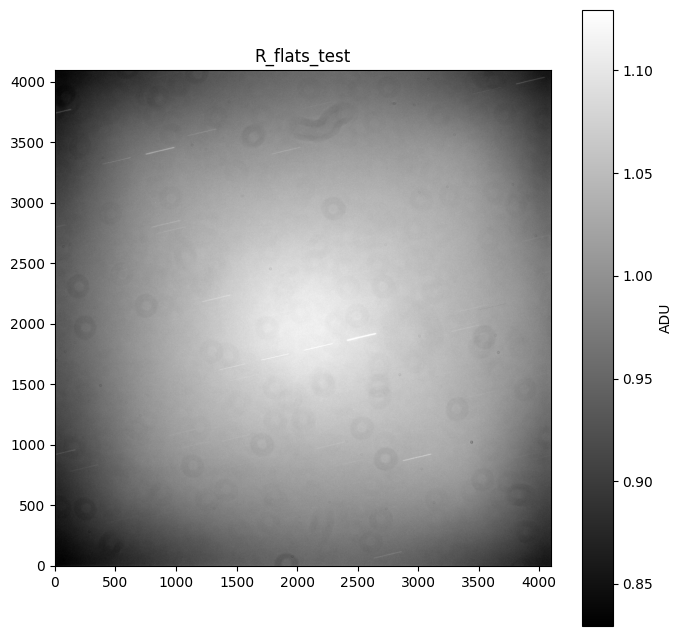

In [11]:
plot_single(master_flat_R, "R_flats_test")

In [12]:
# Calibrate the Science Frames (R-filter)
########################################################
calibration_pipline(R_files, master_dark, master_flat_R, 'calibrated_R_frames', 'calibrated_R')

Processing frame 1/70: R/M8_R_079_2025_00000-27914.fits


/usr/local/lib/python3.12/dist-packages/astropy/units/quantity.py:653: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/lib/python3.12/dist-packages/astropy/nddata/nduncertainty.py:877: RuntimeWarning: invalid value encountered in divide
  (left + right + correlation_sign * corr)


Processing frame 2/70: R/M8_R_079_2025_00000-27915.fits
Processing frame 3/70: R/M8_R_079_2025_00000-27916.fits
Processing frame 4/70: R/M8_R_079_2025_00000-27917.fits
Processing frame 5/70: R/M8_R_079_2025_00000-27918.fits
Processing frame 6/70: R/M8_R_079_2025_00000-27919.fits
Processing frame 7/70: R/M8_R_079_2025_00000-27920.fits
Processing frame 8/70: R/M8_R_079_2025_00000-27921.fits
Processing frame 9/70: R/M8_R_079_2025_00000-27922.fits
Processing frame 10/70: R/M8_R_079_2025_00000-27923.fits
Processing frame 11/70: R/M8_R_079_2025_00000-27924.fits
Processing frame 12/70: R/M8_R_079_2025_00000-27925.fits
Processing frame 13/70: R/M8_R_079_2025_00000-27926.fits
Processing frame 14/70: R/M8_R_079_2025_00000-27927.fits
Processing frame 15/70: R/M8_R_079_2025_00000-27928.fits
Processing frame 16/70: R/M8_R_079_2025_00000-27929.fits
Processing frame 17/70: R/M8_R_079_2025_00000-27930.fits
Processing frame 18/70: R/M8_R_079_2025_00000-27931.fits
Processing frame 19/70: R/M8_R_079_2025

In [13]:
calibrated_R_files = sorted(glob.glob('calibrated_R_frames/calibrated_R_*.fits'))

combine_frames(calibrated_R_files, 'calibrated_R.fits')

Added 10/70 frames
Added 20/70 frames
Added 30/70 frames
Added 40/70 frames
Added 50/70 frames
Added 60/70 frames
Added 70/70 frames


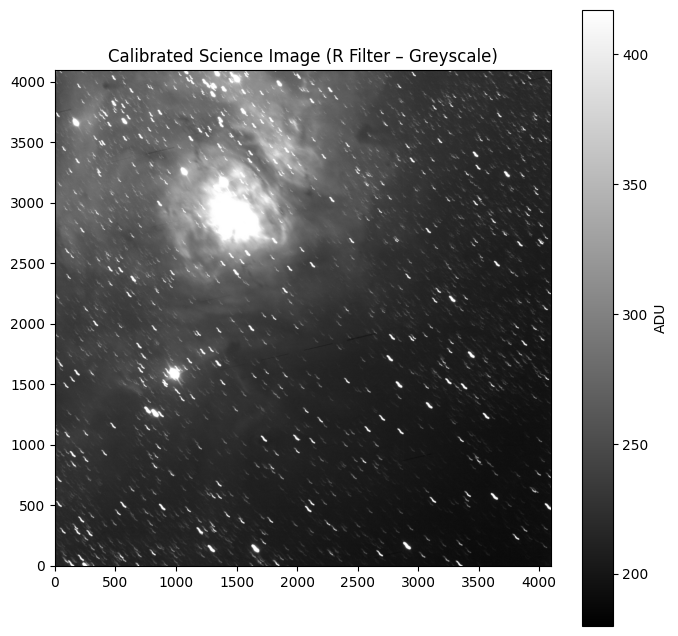

In [14]:
# for debugging
######################
# visualize the Red filter
data_R = fits.getdata('calibrated_R.fits')
plot_single(data_R, "Calibrated Science Image (R Filter – Greyscale)")

BLUE

In [11]:
#  Master Flat for B filter
########################################################
# Read flat files
flat_list_B = [CCDData.read(f, unit='adu') for f in flat_files_B]

# Subtract 10s master dark frame
flat_corr_B = [ccdproc.subtract_dark(f,
                                     master_flat_dark,
                                     exposure_time='EXPTIME',
                                     exposure_unit=u.second,
                                     scale = False
                                     ) for f in flat_list_B]

# Combine and normalize
master_flat_B = ccdproc.combine(flat_corr_B, method='median', sigma_clip=True, sigma_clip_low_thresh=3, sigma_clip_high_thresh=5, sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)
master_flat_B = master_flat_B.divide(np.median(master_flat_B.data))
master_flat_B.write('master_flat_B.fits', overwrite=True)

In [12]:
# Calibrate the Science Frames (B-filter)
########################################################
calibration_pipline(B_files, master_dark, master_flat_B, 'calibrated_B_frames', 'calibrated_B')

Processing frame 1/70: B/M8_B_079_2025_00001-27984.fits


/usr/local/lib/python3.12/dist-packages/astropy/units/quantity.py:653: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/lib/python3.12/dist-packages/astropy/nddata/nduncertainty.py:877: RuntimeWarning: invalid value encountered in divide
  (left + right + correlation_sign * corr)


Processing frame 2/70: B/M8_B_079_2025_00001-27985.fits
Processing frame 3/70: B/M8_B_079_2025_00001-27986.fits
Processing frame 4/70: B/M8_B_079_2025_00001-27987.fits
Processing frame 5/70: B/M8_B_079_2025_00001-27988.fits
Processing frame 6/70: B/M8_B_079_2025_00001-27989.fits
Processing frame 7/70: B/M8_B_079_2025_00001-27990.fits
Processing frame 8/70: B/M8_B_079_2025_00001-27991.fits
Processing frame 9/70: B/M8_B_079_2025_00001-27992.fits
Processing frame 10/70: B/M8_B_079_2025_00001-27993.fits
Processing frame 11/70: B/M8_B_079_2025_00001-27994.fits
Processing frame 12/70: B/M8_B_079_2025_00001-27995.fits
Processing frame 13/70: B/M8_B_079_2025_00001-27996.fits
Processing frame 14/70: B/M8_B_079_2025_00001-27997.fits
Processing frame 15/70: B/M8_B_079_2025_00001-27998.fits
Processing frame 16/70: B/M8_B_079_2025_00001-27999.fits
Processing frame 17/70: B/M8_B_079_2025_00001-28000.fits
Processing frame 18/70: B/M8_B_079_2025_00001-28001.fits
Processing frame 19/70: B/M8_B_079_2025

In [13]:
calibrated_B_files = sorted(glob.glob('calibrated_B_frames/calibrated_B_*.fits'))

combine_frames(calibrated_B_files, 'calibrated_B.fits')

Added 10/70 frames
Added 20/70 frames
Added 30/70 frames
Added 40/70 frames
Added 50/70 frames
Added 60/70 frames
Added 70/70 frames


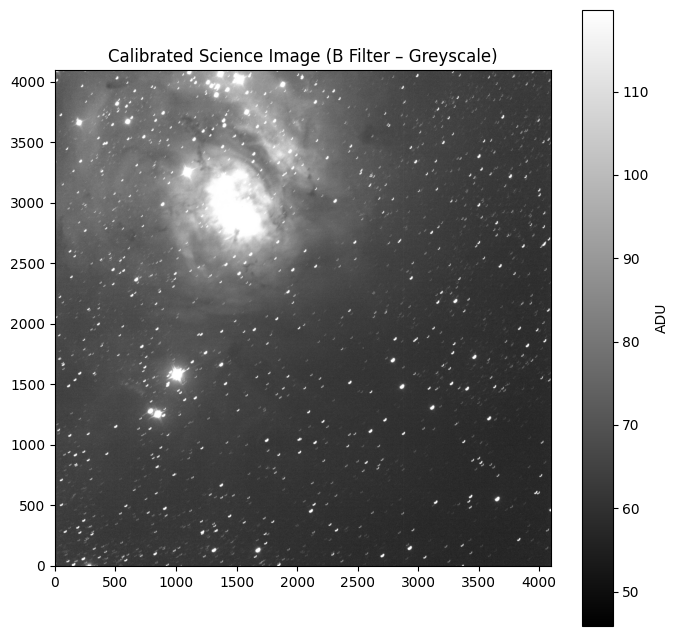

In [14]:
# for debugging
######################
# visualize the Blue filter
data_B = fits.getdata('calibrated_B.fits')
plot_single(data_B, "Calibrated Science Image (B Filter – Greyscale)")

## Stack colored filters

In [15]:
# Read calibrated FITS data
R = fits.getdata('calibrated_R.fits')
V = fits.getdata('calibrated_V.fits')
B = fits.getdata('calibrated_B.fits')

# faulty
##########################################################
# # Clean NaNs/Infs
# R = np.nan_to_num(R, nan=0.0, posinf=0.0, neginf=0.0)
# V = np.nan_to_num(V, nan=0.0, posinf=0.0, neginf=0.0)
# B = np.nan_to_num(B, nan=0.0, posinf=0.0, neginf=0.0)

# # normalize fits
# def normalize(img):
#     lo, hi = np.percentile(img, (0.5, 99.5))  # cut extreme 1% tails
#     img = np.clip((img - lo) / (hi - lo), 0, 1)
#     return img

# Rn = normalize(R)
# Vn = normalize(V)
# Bn = normalize(B)
##########################################################

# Replace NaNs and normalize roughly
def clean(img):
    img = np.nan_to_num(img, nan=0.0)
    lo, hi = np.percentile(img, (0.5, 99.5))
    img = np.clip((img - lo) / (hi - lo), 0, 1)
    return img

R = clean(R)
V = clean(V)
B = clean(B)


# sanity check
print("After cleaning and normalization:")
for name, arr in zip(['R','V','B'], [R,V,B]):
    print(f"{name}: min={arr.min():.2f}, max={arr.max():.2f}, mean={arr.mean():.2f}")

After cleaning and normalization:
R: min=0.00, max=1.00, mean=0.13
V: min=0.00, max=1.00, mean=0.11
B: min=0.00, max=1.00, mean=0.15


In [16]:
from scipy.ndimage import shift
R_shifted = shift(R, shift=(20, 40))
B_shifted = shift(B, shift=(10, 10))

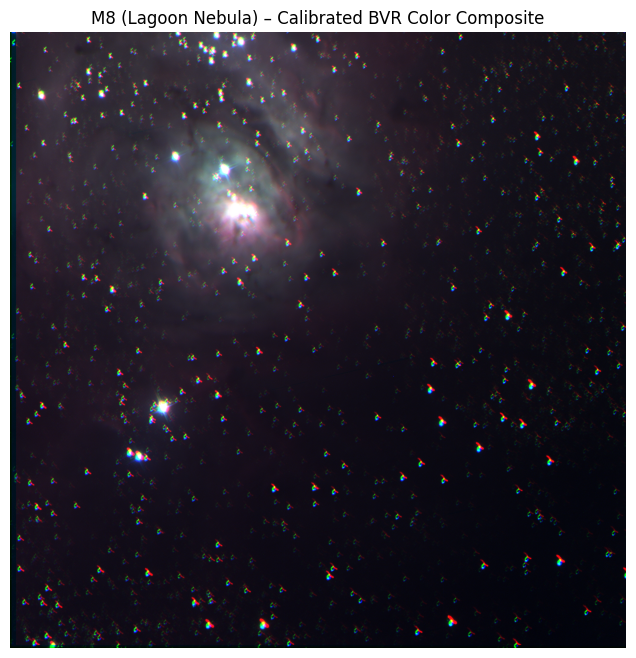

In [17]:
# Stack into RGB
rgb_aligned = np.dstack((R_shifted, V, B_shifted))
rgb_aligned = np.clip(rgb_aligned, 0, 1)

# Convert RGB image (float32 for compact size)
rgb_fits = rgb_aligned.astype('float32')

# Save to FITS file
fits.writeto('combined_BVR.fits', rgb_fits, overwrite=True)

# Display
plt.figure(figsize=(8,8))
plt.imshow(rgb_fits, origin='lower')
plt.axis('off')
#plt.savefig('M8_RGB.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.title("M8 (Lagoon Nebula) – Calibrated BVR Color Composite")
plt.show()